In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from generate_ellipses import get_ellipses_dataset, get_disk_dist_ellipses_dataset
from Model_arch_reg import Net
import deepinv as dinv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"number of GPUs: {torch.cuda.device_count()}")

Using device: cuda
number of GPUs: 2


/home/ktaghavi/miniconda3/envs/msc_dip_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
disk_train = get_disk_dist_ellipses_dataset(fold="train", im_size = 256, length = 5000, max_n_ellipse = 40)
disk_val = get_disk_dist_ellipses_dataset(fold="val", im_size = 256, length = 1000, max_n_ellipse = 40)


(-0.5, 255.5, 255.5, -0.5)

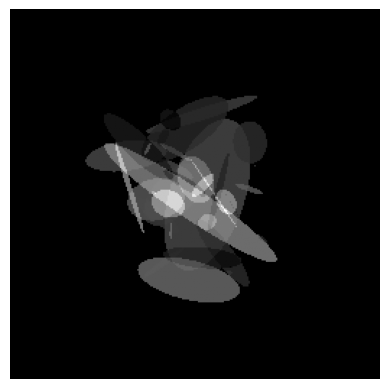

In [3]:
ellipses_test = disk_train[0][0].squeeze(0).numpy()

plt.imshow(ellipses_test, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

In [4]:
ds_data_train = DataLoader(disk_train, batch_size=16)
ds_data_val = DataLoader(disk_val, batch_size=16)

In [5]:
model = Net(256, 1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
angles_torch = torch.linspace(0,180,60,device=device)


In [7]:
os.makedirs('checkpoints', exist_ok=True)
best_wass = float('inf')

epochs = 200
for epoch in range(epochs):
    rand_sigma_train = np.random.uniform(0.1, 5.0)
    physics_train = dinv.physics.Tomography(
        img_width=256, 
        angles=angles_torch, 
        device=device,
        noise_model=dinv.physics.GaussianNoise(sigma=rand_sigma_train),
    )
    model.train()
    running_train = 0.0
    for real_img in ds_data_train:
        real_img = real_img.to(device)

        # 1) Forward + forward backproj → fake images
        with torch.no_grad():
            sinogram= physics_train(real_img)
            # sinogram  = physics_raw.A(real_img)
            noise_img = physics_train.A_dagger(sinogram)
            # img_np = real_img[0][0].squeeze().detach().cpu().numpy()
            # noise_img_np = noise_img[0][0].squeeze().detach().cpu().numpy()
            # plt.imshow(img_np, cmap='gray')
            # plt.title('Real Image')
            # plt.axis('off')
            # plt.show()
            # plt.imshow(noise_img_np, cmap='gray')
            # plt.title('Noisy Image')
            # plt.axis('off')
            # plt.show()
            

        # 2) Critic scores
        D_real = model(real_img).mean()
        D_fake = model(noise_img).mean()

        # 3) Wasserstein term
        L_wass = D_real - D_fake

        # 4) Gradient penalty
        alpha    = torch.rand(real_img.size(0),1,1,1, device=device)
        interp   = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)
        
        D_interp = model(interp)
        grads    = torch.autograd.grad(outputs=D_interp.sum(),
                                    inputs=interp,
                                    create_graph=True)[0]
        grad_norm= grads.view(grads.size(0), -1).norm(2, dim=1)
        L_gp     = ((grad_norm - 1)**2).mean()

        # 5) Critic update
        lambda_gp = 10.0
        loss = L_wass + lambda_gp * L_gp
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train += loss.item() * real_img.size(0)

    print(f"Epoch {epoch:02d} train Loss: {running_train/len(ds_data_train):.4f} with noise level {rand_sigma_train:.2f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_fake.item():.4f}")

    running_test = 0.0
    n_batches = 0
    running_wass = 0.0

    model.eval()
    rand_sigma_test = np.random.uniform(0.1, 5.0)
    physics_test = dinv.physics.Tomography(
        img_width=256, 
        angles=angles_torch, 
        device=device,
        noise_model=dinv.physics.GaussianNoise(sigma=rand_sigma_test),
    )
    with torch.no_grad():
        for real_img in ds_data_val:
            n_batches += 1
            real_img = real_img.to(device)
            sinogram = physics_test(real_img)
            noise_img = physics_test.A_dagger(sinogram)
            D_real = model(real_img).mean()
            D_noise = model(noise_img).mean()

            L_wass = D_real - D_noise 
            alpha = torch.rand(real_img.size(0),1,1,1, device=device)
            intrep = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)

            with torch.enable_grad():
                D_intrep = model(intrep)
                grad_intrep = torch.autograd.grad(
                outputs=D_intrep.sum(), inputs=intrep,
                create_graph=True
                )[0]
        
            grad_norm = grad_intrep.view(grad_intrep.size(0), -1).norm(2, dim=1)
            L_gp = ((grad_norm - 1)**2).mean()
            lambda_gp = 10.0
            
            loss = L_wass + lambda_gp * L_gp
            running_test += loss.item()
            running_wass += L_wass.item()

    avg_loss = running_test / n_batches

    avg_wass = running_wass / n_batches

    # if avg_wass < best_wass:
    #     best_wass = avg_wass
    #     torch.save(model.state_dict(), 'checkpoints/pre_model_reg_FBP_high.pth')
    #     print(f"New best WGAN gap: {avg_wass:.4f} at epoch {epoch}")
    #     print(f"Best model saved at epoch {epoch}")

    torch.save(model.state_dict(), 'checkpoints/pre_model_reg_FBP_high.pth')
    print(f"Epoch {epoch:02d} test Loss: {avg_loss:.4f}, with noise level {rand_sigma_test:.2f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_noise.item():.4f}")

Epoch 00 train Loss: -1666.7028 with noise level 3.16
D_real = -86.0481, D_fake = 140.3826
Epoch 00 test Loss: -48.1313, with noise level 1.82
D_real = -77.8839, D_fake = 57.4973
Epoch 01 train Loss: -297.0124 with noise level 0.68
D_real = -35.6497, D_fake = -10.8013
Epoch 01 test Loss: -17.2477, with noise level 0.60
D_real = -34.7449, D_fake = -11.6600
Epoch 02 train Loss: -1524.4032 with noise level 2.39
D_real = -38.3230, D_fake = 108.4630
Epoch 02 test Loss: 13.8015, with noise level 0.34
D_real = -37.1485, D_fake = -6.4354
Epoch 03 train Loss: -1170.1454 with noise level 1.96
D_real = -49.5599, D_fake = 61.5299
Epoch 03 test Loss: -201.1614, with noise level 4.44
D_real = -48.7136, D_fake = 184.2718
Epoch 04 train Loss: -2635.8815 with noise level 3.33
D_real = -44.6129, D_fake = 220.7473
Epoch 04 test Loss: -192.0950, with noise level 3.67
D_real = -41.7201, D_fake = 250.9036
Epoch 05 train Loss: -2811.6263 with noise level 3.44
D_real = -105.5140, D_fake = 187.9333
Epoch 05 te

KeyboardInterrupt: 

In [ ]:
model_bp = Net(256, 1).to(device)
opt = torch.optim.Adam(model_bp.parameters(), lr=1e-4)

In [ ]:
ds_data_train_bp = DataLoader(disk_train, batch_size=16)
ds_data_val_bp = DataLoader(disk_train, batch_size=16)

In [ ]:
os.makedirs('checkpoints', exist_ok=True)
best_wass = float('inf')

epochs = 200
for epoch in range(epochs):
    model_bp.train()
    rand_sigma_train = np.random.uniform(0.1, 5.0)
    physics_train = dinv.physics.Tomography(
        img_width=256, 
        angles=angles_torch, 
        device=device,
        noise_model=dinv.physics.GaussianNoise(sigma=rand_sigma_train),
    )
    running_train = 0.0
    for real_img in ds_data_train_bp:
        real_img = real_img.to(device)
        # real_img = real_img.unsqueeze(1) 
        # 1) Forward + backproj → fake images
        with torch.no_grad():
            sinogram  = physics_train(real_img)
            noise_img = physics_train.A_adjoint(sinogram)
            # Normalize and clamp the noise image
            # This is important to ensure the noise image is in the same range as the real image
            noise_img = (noise_img - noise_img.mean())/(noise_img.std() + 1e-8)
            noise_img = torch.clamp(noise_img, 0, 1)
            
            img_np = real_img[0][0].squeeze().detach().cpu().numpy()
            noise_img_np = noise_img[0][0].squeeze().detach().cpu().numpy()
            # plt.imshow(img_np, cmap='gray')
            # plt.title('Real Image')
            # plt.axis('off')
            # plt.show()
            # plt.imshow(noise_img_np, cmap='gray')
            # plt.title('Noisy Image')
            # plt.axis('off')
            # plt.show()


        # 2) Critic scores
        D_real = model_bp(real_img).mean()
        D_fake = model_bp(noise_img).mean()

        # 3) Wasserstein term
        L_wass = D_real - D_fake

        # 4) Gradient penalty
        alpha    = torch.rand(real_img.size(0),1,1,1, device=device)
        interp   = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)
        
        D_interp = model_bp(interp)
        grads    = torch.autograd.grad(outputs=D_interp.sum(),
                                    inputs=interp,
                                    create_graph=True)[0]
        grad_norm= grads.view(grads.size(0), -1).norm(2, dim=1)
        L_gp     = ((grad_norm - 1)**2).mean()

        # 5) Critic update
        lambda_gp = 10.0
        loss = L_wass + lambda_gp * L_gp
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train += loss.item() * real_img.size(0)

    print(f"Epoch {epoch:02d} train Loss: {running_train/len(ds_data_train_bp):.4f}, with noise level {rand_sigma_train:.2f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_fake.item():.4f}")

    running_test = 0.0
    running_wass = 0.0

    n_batches = 0
    model_bp.eval()

    rand_sigma_test = np.random.uniform(0.1, 5.0)
    physics_test = dinv.physics.Tomography(
        img_width=256, 
        angles=angles_torch, 
        device=device,
        noise_model=dinv.physics.GaussianNoise(sigma=rand_sigma_test),
    )
    with torch.no_grad():
        for real_img in ds_data_val_bp:
            n_batches += 1
            real_img = real_img.to(device)
            # real_img = real_img.unsqueeze(1)
            sinogram = physics_test(real_img)
            noise_img = physics_test.A_adjoint(sinogram)
            # Normalize and clamp the noise image
            # This is important to ensure the noise image is in the same range as the real image
            noise_img = (noise_img - noise_img.mean())/(noise_img.std() + 1e-8)
            noise_img = torch.clamp(noise_img, 0, 1)

            D_real = model_bp(real_img).mean()
            D_noise = model_bp(noise_img).mean()

            L_wass = D_real - D_noise
            alpha = torch.rand(real_img.size(0),1,1,1, device=device)
            intrep = (alpha * real_img + (1 - alpha) * noise_img).requires_grad_(True)

            with torch.enable_grad():
                D_intrep = model_bp(intrep)
                grad_intrep = torch.autograd.grad(
                outputs=D_intrep.sum(), inputs=intrep,
                create_graph=True
                )[0]

            grad_norm = grad_intrep.view(grad_intrep.size(0), -1).norm(2, dim=1)
            L_gp = ((grad_norm - 1)**2).mean()
            lambda_gp = 10.0

            loss = L_wass + lambda_gp * L_gp
            running_test += loss.item()
            running_wass += L_wass.item()
            
    avg_loss = running_test / n_batches
    avg_wass = running_wass / n_batches

    # if avg_wass < best_wass:
    #     best_wass = avg_wass
    #     torch.save(model_bp.state_dict(), 'checkpoints/pre_model_reg_BP_high.pth')
    #     print(f"New best WGAN gap: {avg_wass:.4f} at epoch {epoch}")
    #     print(f"Best model saved at epoch {epoch}")
    
    torch.save(model_bp.state_dict(), 'checkpoints/pre_model_reg_BP_high.pth')
    print(f"Epoch {epoch:02d} test Loss: {avg_loss:.4f}, with noise level {rand_sigma_test:.2f}")
    print(f"D_real = {D_real.item():.4f}, D_fake = {D_noise.item():.4f}")